## Training

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [53]:
import pandas as pd
from config import conf
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from scripts.transforms import normalize, rescale
from scripts.dataset import PlanetDataSet
import plotly.express as px

In [49]:
data_df = pd.read_csv(conf.data_file)
data_df["lc_sub_tags"] = data_df["lc_sub_tags"].fillna("none")
data_df["lc_tags"] = data_df["lc_tags"].fillna("none")
data_df.head(2)

,Unnamed: 0,id,multiple,lc_tags,lc_sub_tags,degraded_forest,topo_tags
0,0,KN_TRI_000442,True,Grassland,Grassland,NaN,bush
1,1,KN_TRI_003380,True,Grassland,Wood Shrub,NaN,bush


In [46]:
data_df = data_df[~data_df["degraded_forest"].isna()]
data_df["degraded_forest"] = data_df["degraded_forest"].astype(str)
len(data_df)

2916

In [50]:
transforms = T.Compose([
    rescale((32,32)),
    # normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
])

In [51]:
planet_dataset = PlanetDataSet(
    root=conf.train_imgs_path, 
    data_df=data_df,
    label_col="lc_tags",
    transforms=transforms
)
all_tags_dict = planet_dataset.class_to_idx
all_tags_dict

{'Cropland': 0,
 'Wetland': 1,
 'Settlement': 2,
 'Otherland': 3,
 'Forest': 4,
 'Grassland': 5}

In [71]:
degraded_df = data_df.groupby(by=["lc_tags"]).count().reset_index()
degraded_df = degraded_df.sort_values(by=["lc_sub_tags"], ascending=False)
degraded_df

,lc_tags,Unnamed: 0,id,multiple,lc_sub_tags,degraded_forest,topo_tags
2,Grassland,7042,7042,7040,7042,0,6794
1,Forest,2918,2918,2918,2918,2916,2517
3,Otherland,662,662,662,662,0,377
4,Settlement,87,87,87,87,0,56
5,Wetland,66,66,66,66,0,36
0,Cropland,35,35,35,35,0,35


In [79]:
grassland = data_df[data_df.lc_tags == "Grassland"].sample(90)
forest = data_df[data_df.lc_tags == "Forest"].sample(90)
other_land = data_df[data_df.lc_tags == "Otherland"].sample(90)
rest = data_df[~data_df.lc_tags.isin(["Grassland", "Forest", "Otherland"])]

lc_df = pd.concat([grassland,forest,other_land,rest])

lc_df = lc_df.groupby(by=["lc_tags"]).count().reset_index()
lc_df = lc_df.sort_values(by=["lc_sub_tags"], ascending=False)
lc_df

,lc_tags,Unnamed: 0,id,multiple,lc_sub_tags,degraded_forest,topo_tags
1,Forest,90,90,90,90,90,76
2,Grassland,90,90,90,90,0,87
3,Otherland,90,90,90,90,0,50
4,Settlement,87,87,87,87,0,56
5,Wetland,66,66,66,66,0,36
0,Cropland,35,35,35,35,0,35


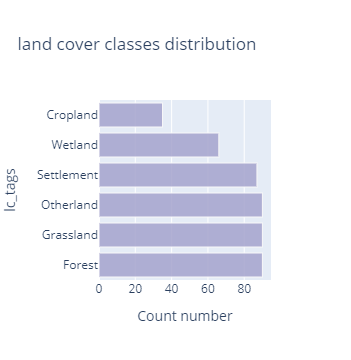

In [81]:
fig = px.bar(
    lc_df, 
    y="lc_tags", 
    x="multiple", 
    title="land cover classes distribution",
    orientation='h',
    labels={
        "lc_tags" : "lc_tags",
        "multiple" : "Count number"
    },
)
fig.update_traces(
    marker=dict(
        color='rgba(164, 163, 204, 0.85)',
        line=dict(color='rgb(248, 248, 249)', width=1)
    )
)
fig.show()